In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.python.framework import graph_util, graph_io

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
from lucid.optvis import objectives, param, render, transform
import matplotlib.pyplot as plt



/home/rlourenco/miniconda3/envs/clouds_lucid/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


512 1184.6848



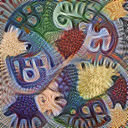

In [2]:
### Sanity check for lucid_tests install
model = models.InceptionV1()
model.load_graphdef()

# rendered
_ = render.render_vis(model, 'mixed4a_pre_relu:476')

# plt.imshow(rendered)



### Import custom model


Needs to import TF-trained model _graph definition_ and _checkpoint_ files

#### If importing a keras model:

In [3]:
# Load keras model
base_folder = '/home/rlourenco/PycharmProjects/clouds_python/output/m14_5layer_per/' # 
#'/Users/ricardobarroslourenco/PycharmProjects/clouds_rdcep/experimental/m19/'
with open((base_folder+'ae.json'), 'r') as file:
    k_model_original = tf.keras.models.model_from_json(file.read())
k_model_original.load_weights(base_folder+'ae.h5')

In [4]:
k_model_original.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ae_input (InputLayer)        (None, 64, 64, 7)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 64, 64, 32)        2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 8, 8, 128)         147584    
__________

In [5]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [6]:
x = inp = Input(shape=(64, 64, 3), name='lucid_input')

def cmap(x):
    m = [1, 0, 2, 2, 0, 0, 0] # Map for RGB starts on zero
    return tf.stack([x[:,:,:,i] for i in m], axis=3)

x = Lambda(cmap)(x)

x = k_model_original(x)


k_model = Model(inp, x)


In [7]:
k_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lucid_input (InputLayer)     (None, 64, 64, 3)         0         
_________________________________________________________________
lambda (Lambda)              (None, 64, 64, 7)         0         
_________________________________________________________________
model (Model)                [(None, 2, 2, 512), (None 11786055  
Total params: 11,786,055
Trainable params: 11,786,055
Non-trainable params: 0
_________________________________________________________________


Insert layer to adapt 

In [8]:
# Convert keras model object to a TF model object
num_output = 1 # Number of outputs (Default = 1). 
pred = [None]*num_output
pred_node_names = [None]*num_output
()
# with open((base_folder+'ae.tf_graphdef'), 'rb' )as file:
#     graph_def.ParseFromString(file.read())
# for node in graph_def.node:
#     print(node.name)
for i in range(num_output):
    pred_node_names[i] = 'output_node'+str(i)
    pred[i] = tf.identity(k_model.outputs[i], name=pred_node_names[i])

print("Output node names are: ", pred_node_names)

sess = tf.keras.backend.get_session()
tf.train.write_graph(sess.graph.as_graph_def(), base_folder, 'ae.tf_graphdef' , as_text=True)
print('Saved graph definition in ascii format at: '+base_folder+'ae.tf_graphdef')

Output node names are:  ['output_node0']
Saved graph definition in ascii format at: /home/rlourenco/PycharmProjects/clouds_python/output/m14_5layer_per/ae.tf_graphdef


In [9]:
# Export weights
constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)
graph_io.write_graph(constant_graph, base_folder, 'ae.tf_weights')
print('Saved TF graph at: '+base_folder+'ae.tf_weights')

INFO:tensorflow:Froze 20 variables.


INFO:tensorflow:Froze 20 variables.


INFO:tensorflow:Converted 20 variables to const ops.


INFO:tensorflow:Converted 20 variables to const ops.


Saved TF graph at: /home/rlourenco/PycharmProjects/clouds_python/output/m14_5layer_per/ae.tf_weights


### Load trained model to Lucid

In [10]:
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    """
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    """
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph
    
frozen_graph = freeze_session(sess, output_names=pred_node_names)
tf.train.write_graph(frozen_graph, base_folder, 'ae_tf_frozen.modelzoo', as_text=False)

INFO:tensorflow:Froze 42 variables.


INFO:tensorflow:Froze 42 variables.


INFO:tensorflow:Converted 42 variables to const ops.


INFO:tensorflow:Converted 42 variables to const ops.


'/home/rlourenco/PycharmProjects/clouds_python/output/m14_5layer_per/ae_tf_frozen.modelzoo'

#### Inspect output node name for graph freeze

In [11]:
from lucid.modelzoo.vision_base import Model

In [12]:
class m19model(Model):
    model_path = (base_folder+'ae_tf_frozen.modelzoo')
    image_shape = [64, 64, 3]
    image_value_range = (0, 1)
    input_name = 'lucid_input'
    

In [13]:
m19lucid = m19model()
m19lucid.load_graphdef()

Display layers:

In [14]:
for node in m19lucid.graph_def.node:
  #if 'Concat' in node.op:
    print(node.name)

conv2d/kernel
conv2d/bias
conv2d_1/kernel
conv2d_1/bias
conv2d_2/kernel
conv2d_2/bias
conv2d_3/kernel
conv2d_3/bias
conv2d_4/kernel
conv2d_4/bias
conv2d_5/kernel
conv2d_5/bias
conv2d_6/kernel
conv2d_6/bias
conv2d_7/kernel
conv2d_7/bias
conv2d_8/kernel
conv2d_8/bias
conv2d_9/kernel
conv2d_9/bias
conv2d_10/kernel
conv2d_10/bias
conv2d_transpose/kernel
conv2d_transpose/bias
conv2d_11/kernel
conv2d_11/bias
conv2d_transpose_1/kernel
conv2d_transpose_1/bias
conv2d_12/kernel
conv2d_12/bias
conv2d_transpose_2/kernel
conv2d_transpose_2/bias
conv2d_13/kernel
conv2d_13/bias
conv2d_transpose_3/kernel
conv2d_transpose_3/bias
conv2d_14/kernel
conv2d_14/bias
conv2d_transpose_4/kernel
conv2d_transpose_4/bias
conv2d_15/kernel
conv2d_15/bias
lucid_input
lambda/strided_slice/stack
lambda/strided_slice/stack_1
lambda/strided_slice/stack_2
lambda/strided_slice
lambda/strided_slice_1/stack
lambda/strided_slice_1/stack_1
lambda/strided_slice_1/stack_2
lambda/strided_slice_1
lambda/strided_slice_2/stack
lambd

In [ ]:
# _  = render.render_vis(m19lucid, 'model/conv2d_5/Conv2D:0')

In [ ]:
# import numpy as np

In [ ]:
# k_model_original.predict(np.random.random((4, 64, 64, 7)))

512 -1.2886885



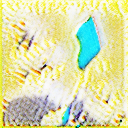

In [15]:
_  = render.render_vis(m19lucid, 'model/conv2d_5/Conv2D:0')

512 -2.0356753



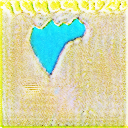

In [16]:
_  = render.render_vis(m19lucid, 'model/conv2d_5/Conv2D:1')

### The most compact layer is conv2d_9

512 533.7164



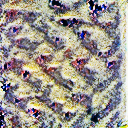

In [17]:
_  = render.render_vis(m19lucid, 'model/conv2d_9/Conv2D:0')

512 -910.06036



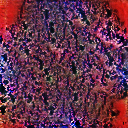

In [18]:
_  = render.render_vis(m19lucid, 'model/conv2d_9/Conv2D:1')

512 -182.71179



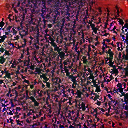

In [19]:
_  = render.render_vis(m19lucid, 'model/conv2d_9/Conv2D:2')

512 -219.73238



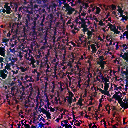

In [20]:
_  = render.render_vis(m19lucid, 'model/conv2d_9/Conv2D:3')

512 -172.21155



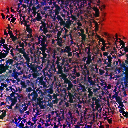

In [21]:
_  = render.render_vis(m19lucid, 'model/conv2d_9/Conv2D:4')

512 -112.060616



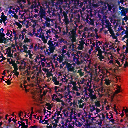

In [22]:
_  = render.render_vis(m19lucid, 'model/conv2d_9/Conv2D:5')

512 -1403.2601



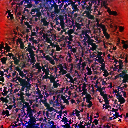

In [23]:
_  = render.render_vis(m19lucid, 'model/conv2d_9/Conv2D:6')

512 -189.6018



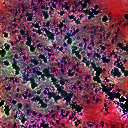

In [24]:
_  = render.render_vis(m19lucid, 'model/conv2d_9/Conv2D:7')

512 -132.5256



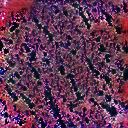

In [25]:
_  = render.render_vis(m19lucid, 'model/conv2d_9/Conv2D:8')

512 -103.98772



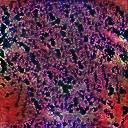

In [26]:
_  = render.render_vis(m19lucid, 'model/conv2d_9/Conv2D:9')

512 -150.90125



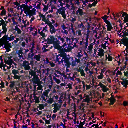

In [28]:
_  = render.render_vis(m19lucid, 'model/conv2d_9/Conv2D:16')

512 1021.8551



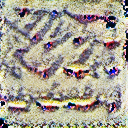

In [29]:
_  = render.render_vis(m19lucid, 'model/conv2d_9/Conv2D:32')

512 -162.06914



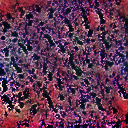

In [30]:
_  = render.render_vis(m19lucid, 'model/conv2d_9/Conv2D:64')

512 -209.42389



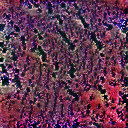

In [31]:
_  = render.render_vis(m19lucid, 'model/conv2d_9/Conv2D:128')

512 -163.9568



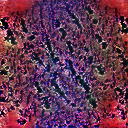

In [32]:
_  = render.render_vis(m19lucid, 'model/conv2d_9/Conv2D:256')

512 471.78165



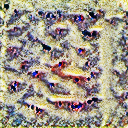

In [34]:
_  = render.render_vis(m19lucid, 'model/conv2d_9/Conv2D:511')

512 589.93677



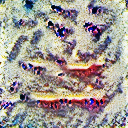

In [35]:
_  = render.render_vis(m19lucid, 'model/conv2d_9/Conv2D:510')